# Bob.FM Hardware FIR Filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
from scipy.fftpack import fft, ifft, fftfreq
import time

In [2]:
def signal_gen(frequency=0.5, amplitude=1, phase_degrees=0, duration=1, 
               sampling_freq=1):
    """A signal generator"""
    phase = phase_degrees * np.pi/180
    try:
        time  = np.arange(0,duration, 1/sampling_freq) # X axis: Time & Samples
    except MemoryError as err:
        print("Please set a shorter duration or smaller sampling frequency")
        time  = np.arange(0,3/frequency, 1/sampling_freq) # X axis: Time & Samples
    
    return time, amplitude*np.sin(2*np.pi*frequency*time+phase)

def dB(voltage):
    """Converts voltage to dB"""
    return 20 * np.log10(voltage)

def rthomp_fft(signal, sampling_freq):
    """Performs an FFT on the signal provided"""
    nfft       = int(5*2**(np.ceil(np.log2(len(signal))))) # Deligating freq bings
    signal_fft = fft(signal, nfft)/len(signal)             # Perform FFT
    fft_freq   = fftfreq(nfft, 1/sampling_freq)            # Extract frequencies
    
    # Taking the magnitude and sectioning off the imag. freq
    signal_fft = dB(2*abs(signal_fft[0:nfft//2]))
    fft_freq   = fft_freq[0:nfft//2]
    
    return fft_freq, signal_fft

### Signal generation

/usr/lib/python3/dist-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


(75000000.0, 150000000.0)

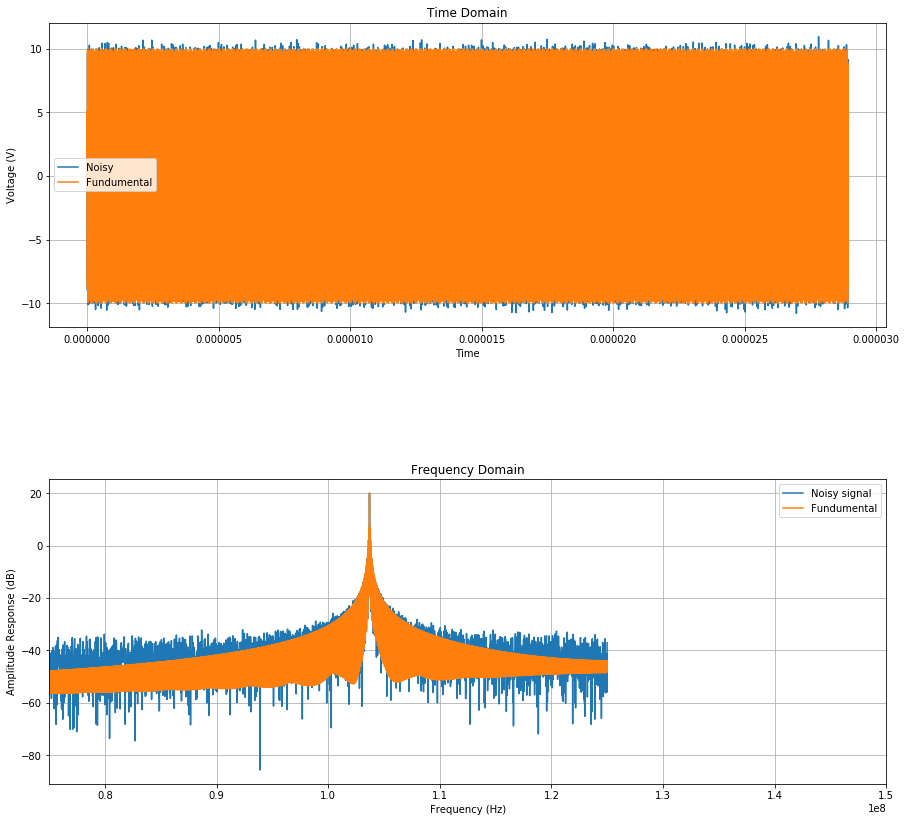

In [3]:
# Fundumental signal
freq = 103.7e6 # bob.fm station
amp = 10     # V
Fs = 250e6
dur = 3e3/freq    # 100.1 cycles
t, s_fundumental = signal_gen(freq,sampling_freq=Fs, duration=dur, amplitude=amp)

# Gaussian noise signal with zero mean and unit variance
variance = .1
stdev = np.sqrt(variance)
noise = np.random.normal(0,stdev,np.size(t))

# Makes the signal noisy
s = (s_fundumental + noise)

# FFTs
nfft, S             = rthomp_fft(s, Fs)
nfft, S_fundumental = rthomp_fft(s_fundumental, Fs)

# Graph
plt.figure('position', [15,14])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title("Time Domain")
plt.plot(t, s, label='Noisy')
plt.plot(t, s_fundumental, label='Fundumental')
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Frequency Domain')
plt.plot(nfft, S, label="Noisy signal")
plt.plot(nfft, S_fundumental, label="Fundumental")
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend()
plt.xlim(75e6,150e6)
# plt.ylim(-50,10)

### Filter Design
This part encapsulates the design decisions of the BOB.FM FIR filter. The HW limitation makes 16bit coefficients the most optimal choice. The bandwidth had to also increase due to the available dsp blocks.
            
    Center Frequency (fr): 103.7MHz
    FM Passband: 200kHz
    Sampling frequency (Fs): 250MHz
    PYNQ-Z1 Limit: 220 DSP Blocks (2 blocks/zero for 16 bit coefficients)
    
References: [T-Filt](http://t-filter.engineerjs.com/), [mytexttools](https://mytexttools.com/find-and-replace-text.html)

Expect a delay of 0.000244ms with 61 coefficients.


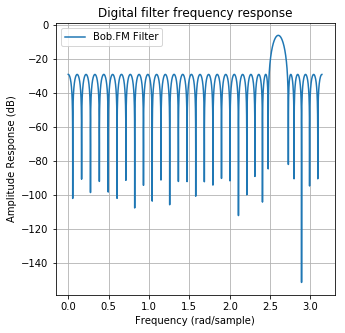

In [4]:
# Filter parameters
b = [-317, 1416, -197, 286, 63, -368, 622, -713, 595, -279, -160, 600, -901, 957, -730, 265, 316, -843, 1154, -1141, 791, -190, -492, 1056, -1332, 1226, -762, 69, 654, -1194, 1395, -1194, 654, 69, -762, 1226, -1332, 1056, -492, -190, 791, -1141, 1154, -843, 316, 265, -730, 957, -901, 600, -160, -279, 595, -713, 622, -368, 63, 286, -197, 1416, -317]
a = 2**16

print('Expect a delay of '+ str(1000*len(b)/Fs) +'ms with '+ str(len(b)) +' coefficients.')
nfft   = int(5*2**(np.ceil(np.log2(len(s)))))
w, response = signal.freqz(b, a, worN=nfft)

# Frequency Response
plt.figure('position', [5,5])
plt.title('Digital filter frequency response')
plt.plot(w, 20 * np.log10(abs(response)), label='Bob.FM Filter')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.legend()

### Software Runtime

/usr/lib/python3/dist-packages/scipy/signal/signaltools.py:1367: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


SW Filter Speed: 48.51865768432617ms


(-80, 25.25892381358983)

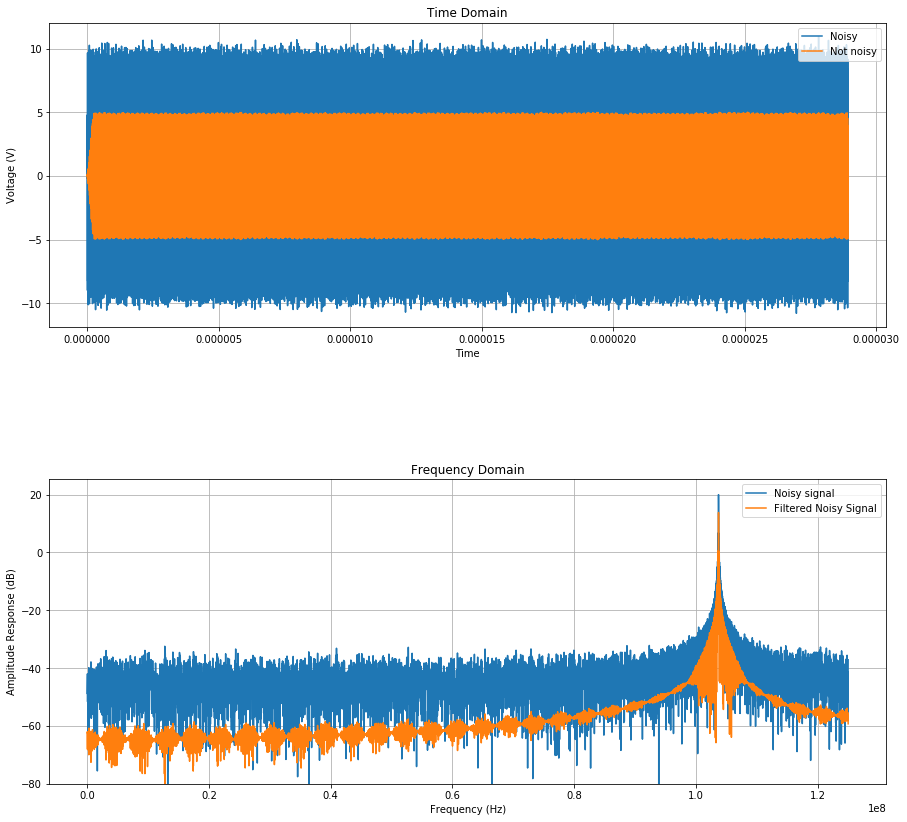

In [5]:
# Filter applied
start_time = time.time()
s_filt = signal.lfilter(b,a,s)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('SW Filter Speed: ' + str(sw_exec_time*1000) + 'ms')

# FFTs
nfft, S = rthomp_fft(s,Fs)
nfft, S_filt = rthomp_fft(s_filt, Fs)

# Graph
plt.figure('position', [15,14])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title("Time Domain")
plt.plot(t, s, label='Noisy')
plt.plot(t, s_filt, label='Not noisy')
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Frequency Domain')
plt.plot(nfft, S, label="Noisy signal")
plt.plot(nfft, S_filt, label="Filtered Noisy Signal")
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend()
plt.ylim(-80)
# plt.xlim(90e6,120e6)

In [6]:
from pynq import Overlay
import pynq.lib.dma
overlay = Overlay('bob_fir.bit')
dma = overlay.fir_fma

Hardware filter speed:  3.1235218048095703 ms
Hardware acceleration factor:  15.533318067323105


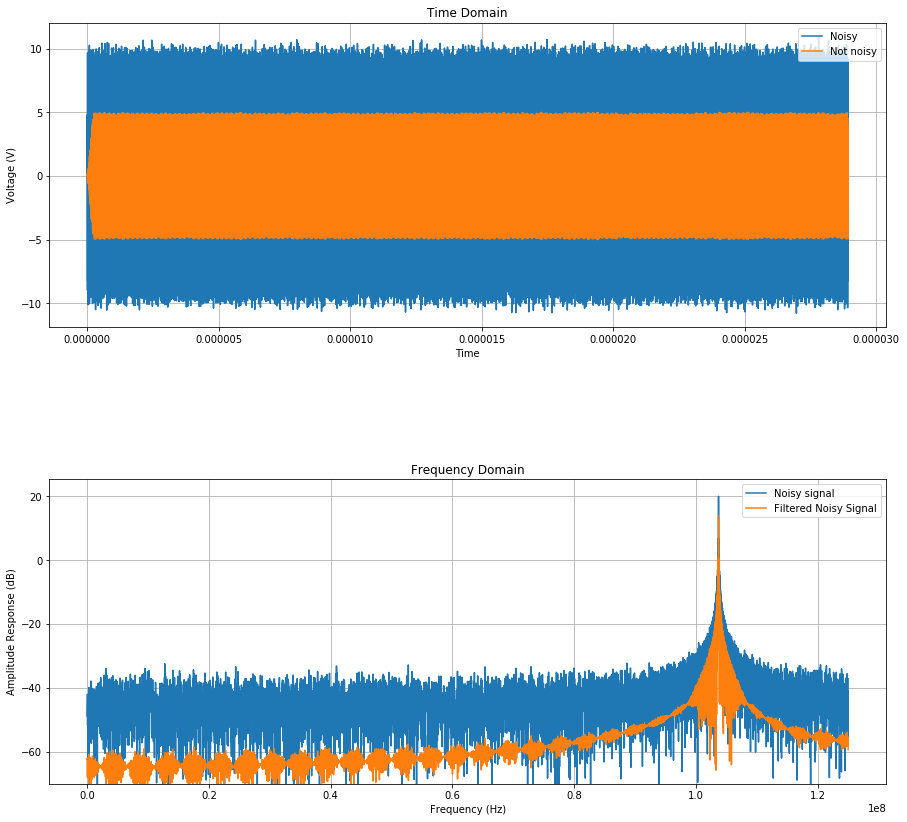

In [7]:
from pynq import Xlnk

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(len(s),), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(len(s),), dtype=np.int32)

# Copy the samples to the in_buffer
s_mv = 1000*s # Convert to mV for hw fir
np.copyto(in_buffer, s_mv.astype(int))


# Trigger the DMA transfer and wait for the result
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware filter speed: ', hw_exec_time*1000, 'ms')
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time)

out_buffer = out_buffer/1000

# FFTs
nfft, S_filt = rthomp_fft(out_buffer, Fs)


# Graph
plt.figure('position', [15,14])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title("Time Domain")
plt.plot(t, s, label='Noisy')
plt.plot(t, out_buffer, label='Not noisy')
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Frequency Domain')
plt.plot(nfft, S, label="Noisy signal")
plt.plot(nfft, S_filt, label="Filtered Noisy Signal")
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend()
plt.ylim(-70)
# plt.xlim(90e6,120e6)


# Free the buffers
in_buffer.close()
out_buffer.close()